# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# Vanilla RNN Implementation

In [3]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.rnn = nn.RNN(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size, device=x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1

# Fine-Tuning on Validation Data

In [5]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 128  # Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [9]:
rnn_word2vec_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_word2vec_model.parameters(), lr=0.001)

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.5210, Accuracy: 0.8769, F1: 0.2697
Validation: Loss: 0.4162, Accuracy: 0.8946, F1: 0.3611
Epoch 2/10
Training: Loss: 0.4001, Accuracy: 0.8973, F1: 0.3792
Validation: Loss: 0.3828, Accuracy: 0.9005, F1: 0.3906
Epoch 3/10
Training: Loss: 0.3749, Accuracy: 0.9026, F1: 0.4153
Validation: Loss: 0.3757, Accuracy: 0.9011, F1: 0.3908
Epoch 4/10
Training: Loss: 0.3569, Accuracy: 0.9059, F1: 0.4353
Validation: Loss: 0.3852, Accuracy: 0.8958, F1: 0.3797
Epoch 5/10
Training: Loss: 0.3491, Accuracy: 0.9075, F1: 0.4500
Validation: Loss: 0.3678, Accuracy: 0.9055, F1: 0.4258
Epoch 6/10
Training: Loss: 0.3361, Accuracy: 0.9106, F1: 0.4662
Validation: Loss: 0.3643, Accuracy: 0.9078, F1: 0.4185
Epoch 7/10
Training: Loss: 0.3355, Accuracy: 0.9110, F1: 0.4702
Validation: Loss: 0.3528, Accuracy: 0.9096, F1: 0.4345
Epoch 8/10
Training: Loss: 0.3291, Accuracy: 0.9129, F1: 0.4766
Validation: Loss: 0.3675, Accuracy: 0.9054, F1: 0.4247
Epoch 9/10
Training: Loss: 0.3231, Accuracy: 0.9

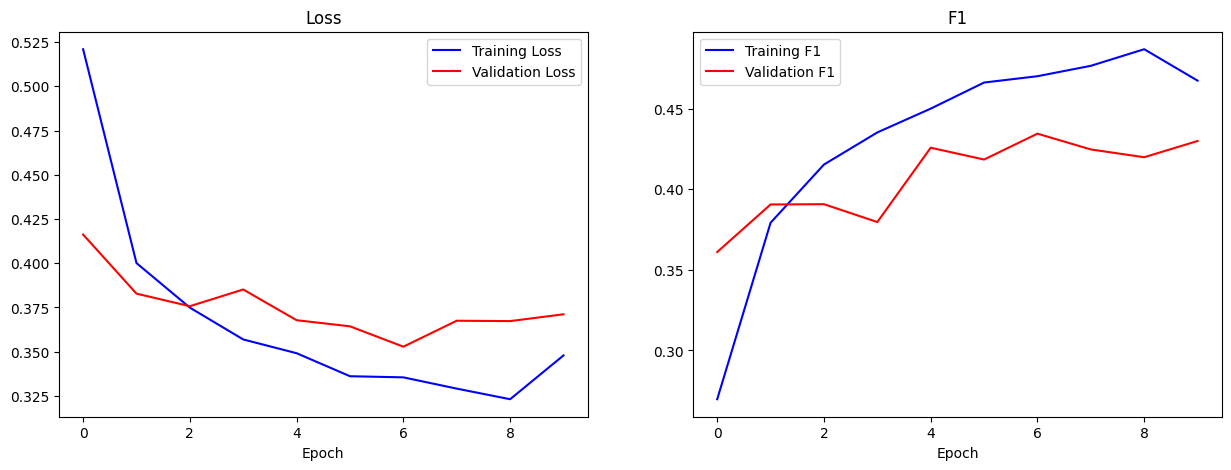

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [12]:
# fine_tune(rnn_word2vec_model, word2vec, val_data, criterion, optimizer, device='cuda', epochs=2)

In [13]:
rnn_word2vec_model = rnn_word2vec_model.to('cpu')
torch.save(rnn_word2vec_model, "t1_model1_word2vec.pt")

In [14]:
test_accuracy, test_f1 = test("t1_model1_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.043066693838082336, 1: 0.04421768707482993, 2: 0.08348030570252793, 3: 0.034278959810874705, 4: 0.023047375160051217, 5: 0.05509641873278237, 6: 0.034552845528455285, 7: 0.09233449477351917, 8: 0.09173553719008265, 9: 0.1771058315334773, 10: 0.17328145265888456, 11: 0.10264900662251657, 12: 0.05045351473922902, 13: 0.04307692307692308, 14: 0.04066985645933014, 15: 0.03981854838709678, 16: 0.2751322751322752, 17: 0.16666666666666666, 18: 0.07142857142857142, 19: 0.048351648351648346, 20: 0.05578417924096937, 21: 0.0, 22: 0.0, 23: 0.09722222222222222, 24: 0.0, 25: 0.0, 26: 0.011661807580174927}
Labelwise Accuracy Scores:
{0: 0.9812454479242535, 1: 0.21487603305785125, 2: 0.4127906976744186, 3: 0.18238993710691823, 4: 0.14516129032258066, 5: 0.43478260869565216, 6: 0.26153846153846155, 7: 0.4774774774774775, 8: 0.5796344647519582, 9: 0.7945736434108527, 10: 0.7643020594965675, 11: 0.6966292134831461, 12: 0.5460122699386503, 13: 0.1206896551724138, 14: 0.28813559

# For GloVe Embeddings

In [15]:
rnn_glove_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_glove_model.parameters(), lr=0.001)
optimizer = optim.SGD(rnn_glove_model.parameters(), lr=0.1)

In [16]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            rnn_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10


Training: Loss: 0.6571, Accuracy: 0.8452, F1: 0.1263
Validation: Loss: 0.7042, Accuracy: 0.8289, F1: 0.1658
Epoch 2/10
Training: Loss: 0.5991, Accuracy: 0.8550, F1: 0.1834
Validation: Loss: 0.5901, Accuracy: 0.8508, F1: 0.2097
Epoch 3/10
Training: Loss: 0.5815, Accuracy: 0.8579, F1: 0.1989
Validation: Loss: 0.6450, Accuracy: 0.8467, F1: 0.2088
Epoch 4/10
Training: Loss: 0.5704, Accuracy: 0.8612, F1: 0.2087
Validation: Loss: 0.6347, Accuracy: 0.8506, F1: 0.2268
Epoch 5/10
Training: Loss: 0.5592, Accuracy: 0.8634, F1: 0.2216
Validation: Loss: 0.5892, Accuracy: 0.8544, F1: 0.2248
Epoch 6/10
Training: Loss: 0.5784, Accuracy: 0.8594, F1: 0.2118
Validation: Loss: 0.6782, Accuracy: 0.8338, F1: 0.2183
Epoch 7/10
Training: Loss: 0.5785, Accuracy: 0.8595, F1: 0.2112
Validation: Loss: 0.5444, Accuracy: 0.8619, F1: 0.2284
Epoch 8/10
Training: Loss: 0.5821, Accuracy: 0.8594, F1: 0.2109
Validation: Loss: 0.6529, Accuracy: 0.8345, F1: 0.1973
Epoch 9/10
Training: Loss: 0.5833, Accuracy: 0.8581, F1: 0.

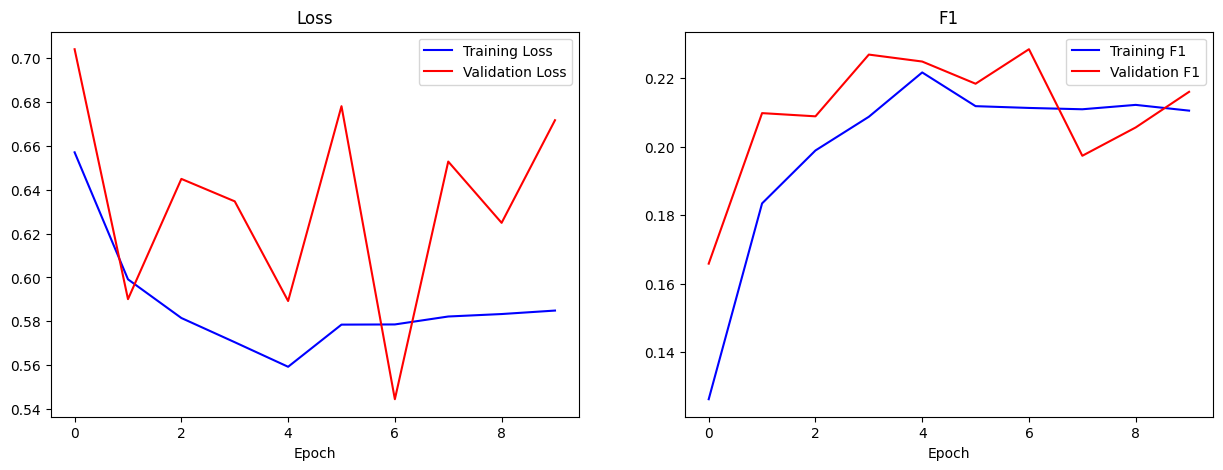

In [17]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [18]:
rnn_glove_model = rnn_glove_model.to('cpu')
torch.save(rnn_glove_model, "t1_model1_glove.pt")

In [19]:
test_accuracy, test_f1 = test("t1_model1_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.06449575092126043, 1: 0.04874551971326165, 2: 0.0570281124497992, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.010050251256281407, 7: 0.1254681647940075, 8: 0.007295173961840629, 9: 0.08419023136246787, 10: 0.08658008658008658, 11: 0.04916943521594685, 12: 0.0714859437751004, 13: 0.0, 14: 0.021907216494845363, 15: 0.07946245983055798, 16: 0.14833333333333334, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.02135678391959799, 21: 0.0, 22: 0.0, 23: 0.16416184971098266, 24: 0.0, 25: 0.0, 26: 0.0}
Labelwise Accuracy Scores:
{0: 0.9369264384559359, 1: 0.2809917355371901, 2: 0.2063953488372093, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.020512820512820513, 7: 0.6036036036036037, 8: 0.033942558746736295, 9: 0.5077519379844961, 10: 0.43478260869565216, 11: 0.20786516853932585, 12: 0.27300613496932513, 13: 0.0, 14: 0.096045197740113, 15: 0.9112227805695142, 16: 0.8018018018018018, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.09340659340659341, 21: 0.0, 22: 0.0, 23: 0.696078431372549, 24: 0.0, 25: 0.0, 26: 0.0}
Vaniila RNN w

# For FastText Embeddings

In [20]:
rnn_fasttext_model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_fasttext_model.parameters(), lr=0.001)

In [21]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        rnn_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.5116, Accuracy: 0.8769, F1: 0.2666
Validation: Loss: 0.4006, Accuracy: 0.8969, F1: 0.3548
Epoch 2/10
Training: Loss: 0.3803, Accuracy: 0.9014, F1: 0.3919
Validation: Loss: 0.3606, Accuracy: 0.9079, F1: 0.4274
Epoch 3/10
Training: Loss: 0.3441, Accuracy: 0.9098, F1: 0.4441
Validation: Loss: 0.3485, Accuracy: 0.9095, F1: 0.4289
Epoch 4/10
Training: Loss: 0.3231, Accuracy: 0.9145, F1: 0.4717
Validation: Loss: 0.3453, Accuracy: 0.9108, F1: 0.4468
Epoch 5/10
Training: Loss: 0.3145, Accuracy: 0.9164, F1: 0.4822
Validation: Loss: 0.3321, Accuracy: 0.9127, F1: 0.4557
Epoch 6/10
Training: Loss: 0.3072, Accuracy: 0.9181, F1: 0.4914
Validation: Loss: 0.3288, Accuracy: 0.9142, F1: 0.4604
Epoch 7/10
Training: Loss: 0.3059, Accuracy: 0.9188, F1: 0.5000
Validation: Loss: 0.3499, Accuracy: 0.9125, F1: 0.4513
Epoch 8/10
Training: Loss: 0.2962, Accuracy: 0.9204, F1: 0.5066
Validation: Loss: 0.3316, Accuracy: 0.9141, F1: 0.4571
Epoch 9/10
Training: Loss: 0.2912, Accuracy: 0.9

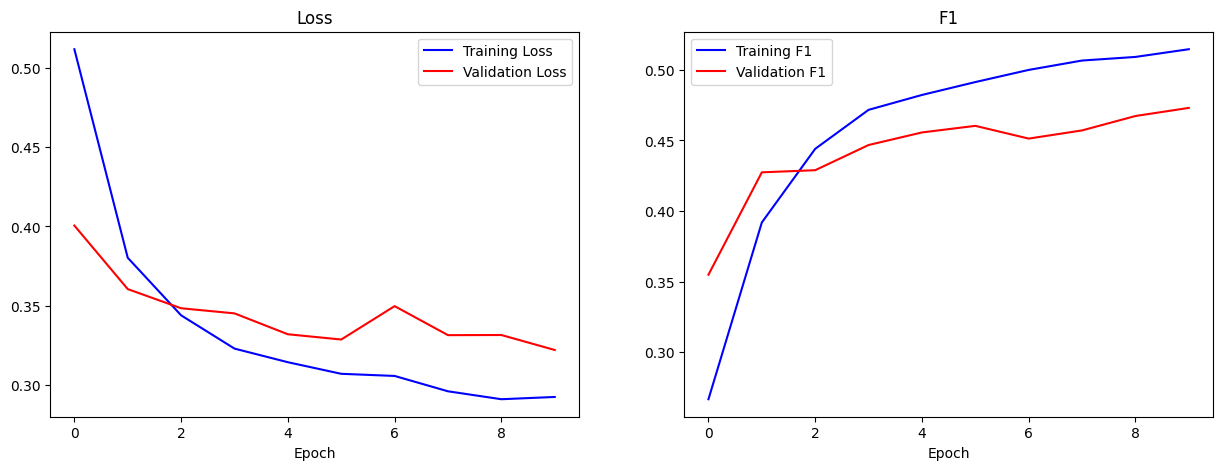

In [22]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [23]:
rnn_fasttext_model = rnn_fasttext_model.to('cpu')
torch.save(rnn_fasttext_model, "t1_model1_fasttext.pt")

In [24]:
test_accuracy, test_f1 = test("t1_model1_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("Vaniila RNN with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.043202608026437175, 1: 0.04647785039941903, 2: 0.0980565371024735, 3: 0.02808302808302808, 4: 0.035199321458863446, 5: 0.08857142857142856, 6: 0.06855791962174941, 7: 0.10025062656641605, 8: 0.1290666666666667, 9: 0.1813559322033898, 10: 0.09116809116809116, 11: 0.11786892975011787, 12: 0.06490944952483414, 13: 0.03125, 14: 0.0448742746615087, 15: 0.04458523198888757, 16: 0.17744360902255638, 17: 0.125, 18: 0.07142857142857142, 19: 0.03278688524590164, 20: 0.05142857142857142, 21: 0.16666666666666669, 22: 0.049999999999999996, 23: 0.1829787234042553, 24: 0.08, 25: 0.0, 26: 0.032407407407407406}
Labelwise Accuracy Scores:
{0: 0.9873998543335761, 1: 0.2644628099173554, 2: 0.6453488372093024, 3: 0.14465408805031446, 4: 0.267741935483871, 5: 0.4492753623188406, 6: 0.4461538461538462, 7: 0.5405405405405406, 8: 0.6318537859007833, 9: 0.8294573643410853, 10: 0.6956521739130435, 11: 0.702247191011236, 12: 0.5552147239263804, 13: 0.10344827586206896, 14: 0.32768361581